# Post analysis for brute-force solutions of alternative stable states

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch import optim

import matplotlib
matplotlib.rcParams.update({'font.size': 11})

filepathold = Path('./data/AltSS/')
filepath = Path('./data/AltSSJun26/') # AltSSJun26 use new initial conditions!
filepathnew = Path('./data/AltSSJul9/') # Jul 6use more strict criterion for stability! 
filepathnewLin = Path('./data/AltSSSep3/') # new for Lin and Log, add steady crierion
# Jul 9 add steady criterion!

num_task = 48 # num of different correlations

C_span = torch.load(Path('./data/')/'AltSSsamplesv1.pt')['C_span']
G_span = torch.load(Path('./data/')/'AltSSsamplesv1.pt')['G_span']

Ns = C_span.shape[2]
Nr = C_span.shape[3]

num_test = C_span.shape[1]

In [2]:
num_AltSS = torch.zeros(num_task,num_test)
num_AltSSLin = torch.zeros(num_task,num_test)
num_AltSSLog = torch.zeros(num_task,num_test)
stable = torch.zeros(num_task,num_test)
stableLin = torch.zeros(num_task,num_test)
stableLog = torch.zeros(num_task,num_test)

for task_id in range(num_task):
    filename = 'v1AltSSdiv'+str(task_id)+'.pt'
    AltSSdiv = torch.load(filepathnew/filename)['AltSSdiv']
    filename = 'v1AltSSdivLin'+str(task_id)+'.pt'
    AltSSdivLin = torch.load(filepathnewLin/filename)['AltSSdiv']
    filename = 'v1AltSSdivLog'+str(task_id)+'.pt'
    AltSSdivLog = torch.load(filepathnewLin/filename)['AltSSdiv']

    breakp = (AltSSdiv == 0.5).nonzero() # the indeces!
    breakpLin = (AltSSdivLin == 0.5).nonzero()
    breakpLog = (AltSSdivLog == 0.5).nonzero()
    for j in range(len(breakp)):
        pl = 1
        if breakp[j]+pl <= len(AltSSdiv)-1:
            while (AltSSdiv[breakp[j]+pl] != 0.5):
                num_AltSS[task_id,j] = num_AltSS[task_id,j] + 1
                if (task_id == 39) & (j == 3):
                    print(AltSSdiv[breakp[j]+pl])
                if AltSSdiv[breakp[j]+pl] == 12.0:
                    stable[task_id,j] = 1
                pl = pl + 1
                if breakp[j]+pl == len(AltSSdiv):
                    break
    for j in range(len(breakpLin)):
        pl = 1
        if breakpLin[j]+pl <= len(AltSSdivLin)-1:
            while (AltSSdivLin[breakpLin[j]+pl] != 0.5):
                num_AltSSLin[task_id,j] = num_AltSSLin[task_id,j] + 1
                if AltSSdivLin[breakpLin[j]+pl] == 12.0:
                    stableLin[task_id,j] = 1
                pl = pl + 1
                if breakpLin[j]+pl == len(AltSSdivLin):
                    break
    for j in range(len(breakpLog)):
        pl = 1
        while breakpLog[j]+pl < len(AltSSdivLog):
            if (AltSSdivLog[breakpLog[j]+pl] != 0.5):
                num_AltSSLog[task_id,j] = num_AltSSLog[task_id,j] + 1
                if AltSSdivLog[breakpLog[j]+pl] == 12.0:
                    stableLog[task_id,j] = 1
            else:
                break
            pl = pl + 1

tensor([12.])
tensor([10.])


In [3]:
'''
## this one is used to get CD
class rescale(nn.Module):
    def __init__(self,Nr):
        super(rescale, self).__init__()
        self.D = nn.Parameter(torch.ones(Nr)) # not sure if devided by sqrt(Nr)

    def forward(self, C):
        output = C @ torch.diag(self.D)
        return output

## the following three used for calculating loss function
def NormalG(G):
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G
    return G

def H(G):
    # normaized to the simplex
    Ns = G.size(dim=0)
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    # G-G distances
    distances = torch.zeros(Ns,Ns)
    for i in range(Ns-1):
        for j in range(i+1, Ns):
            distances[i,j] = torch.linalg.norm(G[i] - G[j])
    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))
    minDis = torch.min(distances, 1).values
    H = torch.mean(minDis)
    return H


def Loss(NG,CD,H):
    # normaized to the simplex
    CD = torch.diag((torch.sum(CD, 1))**(-1)) @ CD

    # G-C distances
    I = torch.mean(torch.linalg.norm(NG - CD, dim=1))

    # G-G distances given by H
    # by definition
    E = I/H
    return E
'''

'\n## this one is used to get CD\nclass rescale(nn.Module):\n    def __init__(self,Nr):\n        super(rescale, self).__init__()\n        self.D = nn.Parameter(torch.ones(Nr)) # not sure if devided by sqrt(Nr)\n\n    def forward(self, C):\n        output = C @ torch.diag(self.D)\n        return output\n\n## the following three used for calculating loss function\ndef NormalG(G):\n    G = torch.diag((torch.sum(G, 1))**(-1)) @ G\n    return G\n\ndef H(G):\n    # normaized to the simplex\n    Ns = G.size(dim=0)\n    G = torch.diag((torch.sum(G, 1))**(-1)) @ G\n\n    # G-G distances\n    distances = torch.zeros(Ns,Ns)\n    for i in range(Ns-1):\n        for j in range(i+1, Ns):\n            distances[i,j] = torch.linalg.norm(G[i] - G[j])\n    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))\n    minDis = torch.min(distances, 1).values\n    H = torch.mean(minDis)\n    return H\n\n\ndef Loss(NG,CD,H):\n    # normaized to the simplex\n    CD = torch.diag((torch.s

In [4]:
'''
# Nr = 12 # be careful
lr = 0.1
epochs = 1000
EGC = torch.zeros(num_task,num_test)

for i in range(num_task):
    for j in range(num_test):
        G = G_span[i,j]
        C = C_span[i,j]
        HG = H(G)
        NorG = NormalG(G)

        layer = rescale(Nr) # get new model!
        opt = optim.SGD(layer.parameters(), lr=lr, momentum=0.9)

        E = 0 # initailize E(G,C)
        # training process
        for epoch in range(epochs):
            CD = layer(C)
            loss = Loss(NorG,CD,HG)

            loss.backward()
            opt.step()
            opt.zero_grad()

            if epoch >= epochs - 100:
                E = (E*(epoch - epochs + 100) + loss.item())/(epoch - epochs + 101)
        
        EGC[i,j] = E
'''

'\n# Nr = 12 # be careful\nlr = 0.1\nepochs = 1000\nEGC = torch.zeros(num_task,num_test)\n\nfor i in range(num_task):\n    for j in range(num_test):\n        G = G_span[i,j]\n        C = C_span[i,j]\n        HG = H(G)\n        NorG = NormalG(G)\n\n        layer = rescale(Nr) # get new model!\n        opt = optim.SGD(layer.parameters(), lr=lr, momentum=0.9)\n\n        E = 0 # initailize E(G,C)\n        # training process\n        for epoch in range(epochs):\n            CD = layer(C)\n            loss = Loss(NorG,CD,HG)\n\n            loss.backward()\n            opt.step()\n            opt.zero_grad()\n\n            if epoch >= epochs - 100:\n                E = (E*(epoch - epochs + 100) + loss.item())/(epoch - epochs + 101)\n        \n        EGC[i,j] = E\n'

(0.0, 1.5)

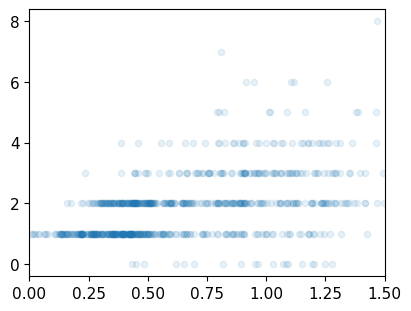

In [5]:
#torch.save({'EGC':EGC}, filepath/'EGCAltv1.pt')
EGC = torch.load(filepathold/'EGCAltv1.pt')['EGC']

plt.figure(figsize=(4, 3),constrained_layout=True)
plt.scatter(EGC,num_AltSS, alpha=.1, s=20)
plt.xlim(.0,1.5)

For linear supply

(0.0, 1.5)

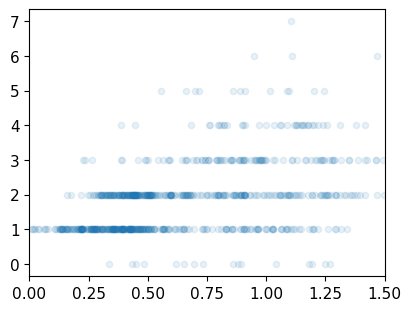

In [6]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.scatter(EGC,num_AltSSLin, alpha=.1, s=20)
plt.xlim(.0,1.5)

For logistic supply

(0.0, 1.5)

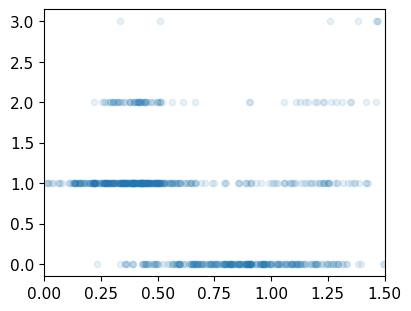

In [7]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.scatter(EGC,num_AltSSLog, alpha=.1, s=20)
plt.xlim(.0,1.5)

Text(0, 0.5, '# of stable attractors')

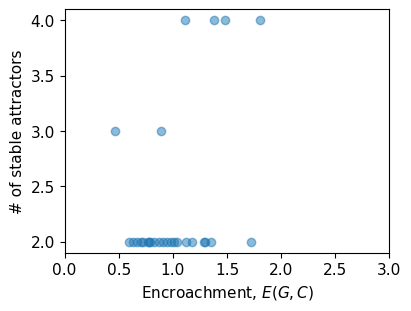

In [8]:
lneqg = ((num_AltSS > 1) & (stable == 1)).nonzero(as_tuple=True)
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.scatter(EGC[lneqg]*2,num_AltSS[lneqg], alpha=0.5)
plt.xlim(.0,3.0)

plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('# of stable attractors')

In [9]:
lneqg

(tensor([11, 14, 16, 18, 19, 20, 20, 22, 23, 23, 25, 26, 27, 28, 29, 29, 30, 30,
         31, 31, 33, 35, 35, 37, 38, 39, 43]),
 tensor([ 7,  1,  9,  8,  0,  5,  6, 15,  2,  8, 11,  7,  9,  8,  7, 12,  4,  8,
          0,  9,  7,  0,  8,  8, 15,  3,  6]))

In [10]:
import math

In [11]:
x_mean = []
y_mean = []
x_std = []
y_std = []

ylin_mean = []
ylin_std = []

ylog_mean = []
ylog_std = []

for i in range(30):
    indeces = ((i*0.05<=EGC) & (EGC<(i+1)*0.05)).nonzero(as_tuple=True)
    x_group = EGC[indeces]
    y_group = num_AltSS[indeces]
    y1_group = num_AltSSLin[indeces]
    y2_group = num_AltSSLog[indeces]
    if x_group.size() != torch.Size([0]):
        NN = len(indeces[0])
        x_mean.append(torch.mean(x_group))
        x_std.append(torch.std(x_group)/math.sqrt(NN))
        y_mean.append(torch.mean(y_group))
        y_std.append(torch.std(y_group)/math.sqrt(NN))
        ylin_mean.append(torch.mean(y1_group))
        ylin_std.append(torch.std(y1_group)/math.sqrt(NN))
        ylog_mean.append(torch.mean(y2_group))
        ylog_std.append(torch.std(y2_group)/math.sqrt(NN))


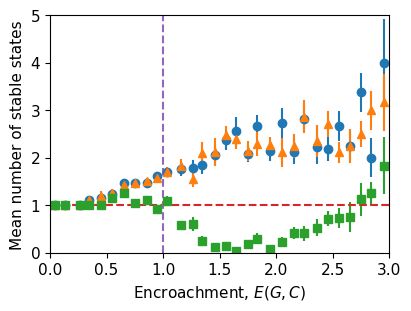

In [12]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.errorbar(2*torch.tensor(x_mean),y_mean, xerr=x_std, yerr= y_std, marker = 'o', ls='none')
plt.errorbar(2*torch.tensor(x_mean),ylin_mean, xerr=x_std, yerr= ylin_std, marker = '^', ls='none')
plt.errorbar(2*torch.tensor(x_mean),ylog_mean, xerr=x_std, yerr= ylog_std, marker = 's', ls='none')
#plt.legend(['Constant','Linear','Logistic'])
plt.plot(torch.linspace(0,3,steps=10),torch.linspace(1.0,1.0,steps=10),'--') # 1 line
plt.plot(torch.linspace(1,1,steps=10),torch.linspace(0,5,steps=10),'--')
plt.xlim(.0,3)
plt.ylim(.0,5)
#plt.yticks(range(0,19,2))
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Mean number of stable states')
plt.savefig('../figures/FigS4emb9.eps', format='eps')

Text(0, 0.5, 'Mean number of stable states')

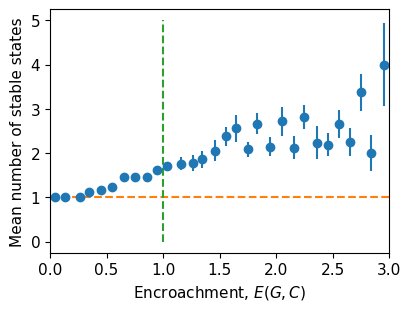

In [15]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.errorbar(2*torch.tensor(x_mean),y_mean, xerr=x_std, yerr= y_std, marker = 'o', ls='none')

#plt.plot(torch.linspace(0,3,steps=100),torch.linspace(12.0,12.0,steps=100),'--') # Ns line
plt.plot(torch.linspace(0,3,steps=10),torch.linspace(1.0,1.0,steps=10),'--') # 1 line
plt.plot(torch.linspace(1,1,steps=10),torch.linspace(0,5,steps=10),'--') 
plt.xlim(.0,3.0)
#plt.ylim(.0,14)
#plt.yticks(range(0,19,2))
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Mean number of stable states')
#plt.savefig('./figures/AltSSmain.eps', format='eps')

In [16]:
from scipy.io import savemat # type: ignore
tensordic = {'x_mean':x_mean, 'y_mean': y_mean, 'x_std':x_std,'y_std':y_std}
#savemat("./Dive in Dynamics/data/bruteforce.mat", tensordic)